# Nenana Ice Classic Modeling
This notebook was used for modeling the NIC data.

In [1]:
# imports

import numpy as np
import pandas as pd

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.preprocessing import RobustScaler, QuantileTransformer, Normalizer
from sklearn.preprocessing import PowerTransformer, KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import WOEEncoder, OrdinalEncoder #TargetEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, cross_validate, cross_val_predict
from sklearn.svm import SVC

# metrics
from sklearn import metrics # explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
#from sklearn.utils import check_arrays # converts list-like objects to array (if needed)

# import datetime

import warnings
warnings.filterwarnings("ignore")
import gc # garbage collection

In [2]:
def stringify(data):
    data = pd.DataFrame(data)
    for c in data.columns.tolist():
        data[c] = data[c].astype(str)
    return data

In [3]:
# read data
df = pd.read_csv('../data/cleaned_data.csv')

In [4]:
df.head()

,Unnamed: 0,Date,moonPhase,humidity,windSpeed,windBearing,uvIndex,temperatureMin,temperatureMax,precipType,precipIntensity,precipAccumulation,winningTime,daylightHours,iceThickness
0,0,1989-03-01,0.80,0.70,8.42,236.0,1.0,20.58,29.65,None,0.0,0.0,0,0.423611,37.5
1,1,1989-03-02,0.83,0.68,8.59,266.0,1.0,-7.38,29.07,None,0.0,0.0,0,0.428472,37.5
2,2,1989-03-03,0.87,0.50,5.84,344.0,1.0,-19.23,1.84,None,0.0,0.0,0,0.433333,37.5
3,3,1989-03-04,0.90,0.51,2.52,6.0,1.0,-30.34,4.69,None,0.0,0.0,0,0.438194,37.5
4,4,1989-03-05,0.94,0.56,1.76,216.0,1.0,-38.53,0.74,None,0.0,0.0,0,0.442361,37.5


In [5]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [6]:
df.shape

(2679, 14)

## Feature Engineering

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2679 entries, 0 to 2678
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                2679 non-null   object 
 1   moonPhase           2679 non-null   float64
 2   humidity            2679 non-null   float64
 3   windSpeed           2679 non-null   float64
 4   windBearing         2679 non-null   float64
 5   uvIndex             2679 non-null   float64
 6   temperatureMin      2679 non-null   float64
 7   temperatureMax      2679 non-null   float64
 8   precipType          2679 non-null   object 
 9   precipIntensity     2679 non-null   float64
 10  precipAccumulation  2679 non-null   float64
 11  winningTime         2679 non-null   object 
 12  daylightHours       2679 non-null   float64
 13  iceThickness        2679 non-null   float64
dtypes: float64(11), object(3)
memory usage: 293.1+ KB


In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df['winningTime'] = pd.to_datetime(df['winningTime'], errors = 'ignore')

In [10]:
# create column for ordinal day of year
df['dayOfYear'] = df['Date'].dt.dayofyear

In [11]:
# create binary 'winningDate' column
df['winningDate'] = 0
idx = df.loc[df['winningTime'] != '0'].index
df['winningDate'].loc[idx] = 1

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2679 entries, 0 to 2678
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2679 non-null   datetime64[ns]
 1   moonPhase           2679 non-null   float64       
 2   humidity            2679 non-null   float64       
 3   windSpeed           2679 non-null   float64       
 4   windBearing         2679 non-null   float64       
 5   uvIndex             2679 non-null   float64       
 6   temperatureMin      2679 non-null   float64       
 7   temperatureMax      2679 non-null   float64       
 8   precipType          2679 non-null   object        
 9   precipIntensity     2679 non-null   float64       
 10  precipAccumulation  2679 non-null   float64       
 11  winningTime         2679 non-null   object        
 12  daylightHours       2679 non-null   float64       
 13  iceThickness        2679 non-null   float64     

In [13]:
df['past'] = (df['Date'] < '2015-01-01').astype(np.int)

In [14]:
df['future'] = 1 - df['past']

In [15]:
df.head().append(df.tail())

,Date,moonPhase,humidity,windSpeed,windBearing,uvIndex,temperatureMin,temperatureMax,precipType,precipIntensity,precipAccumulation,winningTime,daylightHours,iceThickness,dayOfYear,winningDate,past,future
0,1989-03-01,0.80,0.70,8.42,236.0,1.0,20.58,29.65,None,0.0000,0.0,0,0.423611,37.5,60,0,1,0
1,1989-03-02,0.83,0.68,8.59,266.0,1.0,-7.38,29.07,None,0.0000,0.0,0,0.428472,37.5,61,0,1,0
2,1989-03-03,0.87,0.50,5.84,344.0,1.0,-19.23,1.84,None,0.0000,0.0,0,0.433333,37.5,62,0,1,0
3,1989-03-04,0.90,0.51,2.52,6.0,1.0,-30.34,4.69,None,0.0000,0.0,0,0.438194,37.5,63,0,1,0
4,1989-03-05,0.94,0.56,1.76,216.0,1.0,-38.53,0.74,None,0.0000,0.0,0,0.442361,37.5,64,0,1,0
2674,2019-05-27,0.80,0.43,3.90,226.0,4.0,52.65,68.04,rain,0.0003,0.0,0,0.827778,25.3,147,0,0,1
2675,2019-05-28,0.83,0.55,2.27,352.0,4.0,49.06,67.04,rain,0.0008,0.0,0,0.832639,25.3,148,0,0,1
2676,2019-05-29,0.86,0.51,2.54,108.0,4.0,46.89,70.52,rain,0.0001,0.0,0,0.836806,25.3,149,0,0,1
2677,2019-05-30,0.89,0.40,2.75,99.0,5.0,52.30,75.52,rain,0.0001,0.0,0,0.840972,25.3,150,0,0,1
2678,2019-05-31,0.92,0.69,2.29,343.0,3.0,53.73,65.86,rain,0.0067,0.0,0,0.845139,25.3,151,0,0,1


In [16]:
df.loc[df['winningDate'] == 1]

,Date,moonPhase,humidity,windSpeed,windBearing,uvIndex,temperatureMin,temperatureMax,precipType,precipIntensity,precipAccumulation,winningTime,daylightHours,iceThickness,dayOfYear,winningDate,past,future
49,1989-05-01,0.87,0.47,3.72,277.0,4.0,36.22,61.53,None,0.0000,0.0,8:14 PM,0.707639,40.0,121,1,1,0
134,1990-04-24,0.00,0.61,0.00,0.0,4.0,28.66,44.74,None,0.0000,0.0,5:19 PM,0.674306,36.0,114,1,1,0
228,1991-05-01,0.60,0.49,4.13,139.0,4.0,31.43,57.62,None,0.0000,0.0,12:04 AM,0.706250,38.0,121,1,1,0
332,1992-05-14,0.45,0.49,5.83,239.0,5.0,30.52,51.11,None,0.0000,0.0,6:26 AM,0.770833,47.0,135,1,1,0
401,1993-04-23,0.07,0.52,7.72,330.0,4.0,31.28,45.50,None,0.0000,0.0,1:01 PM,0.670139,25.0,113,1,1,0
499,1994-04-29,0.67,0.31,4.39,22.0,4.0,26.51,59.54,None,0.0000,0.0,11:01 PM,0.697222,51.0,119,1,1,0
585,1996-05-05,0.60,0.44,4.42,64.0,4.0,32.47,53.42,None,0.0000,0.0,12:32 PM,0.728472,45.0,126,1,1,0
672,1997-04-30,0.79,0.48,4.05,252.0,3.0,25.75,61.35,None,0.0000,0.0,10:28 AM,0.703472,36.0,120,1,1,0
754,1998-04-20,0.80,0.60,4.06,287.0,3.0,25.97,52.56,rain,0.0000,0.0,4:54 PM,0.654861,38.0,110,1,1,0
921,2000-05-01,0.93,0.46,4.97,211.0,4.0,34.92,55.95,None,0.0000,0.0,10:47 AM,0.709722,36.0,122,1,1,0


The information for 1995 and 1999 are missing some dates, including the winning date. I decided to drop the data for those years, since survival analysis would falsely treat them as censored.

In [17]:
drop_1995_1999 = df.loc[(df['Date'].dt.year == 1995)|(df['Date'].dt.year == 1999)].index

In [18]:
df.drop(index = drop_1995_1999, inplace = True)

In [19]:
df['precipType'].value_counts()

None    2154
snow     231
rain     194
Name: precipType, dtype: int64

In [20]:
# encode precipType
df = df.merge(pd.get_dummies(df['precipType'], prefix = 'precip', drop_first = True, sparse = True),
         how = 'left', left_index = True, right_index = True)

Create column for daily average temperature

In [21]:
df['temperatureAvg'] = (df['temperatureMin'] + df['temperatureMax']) / 2

Create columns for number of "hot days," "cold days," and snow accumulated since Apr 1 in a given year.

I defined a "hot day" as a day where: day_average_temp > median(year_avg_temp) + std_dev(year_avg_temp)

A "cold day" is a day where: day_average_temp < median(year_avg_temp) - std_dev(year_avg_temp)

In [22]:
year_list = sorted(list(set(df['Date'].dt.year)))

In [23]:
year_list

[1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1996,
 1997,
 1998,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019]

In [24]:
hot_count = []
cold_count = []
daily_accumulation = []
for year in year_list:
    hot_temp_count = 0
    cold_temp_count = 0
    daily_accum = 0
    temp_df = df.loc[df['Date'].dt.year == year]
    hot_threshold = temp_df['temperatureAvg'].median() + temp_df['temperatureAvg'].std()
    cold_threshold = temp_df['temperatureAvg'].median() - temp_df['temperatureAvg'].std()
    for idx in temp_df.index:
        current_temp = temp_df['temperatureAvg'].loc[idx]
        if temp_df['precip_snow'].loc[idx] == 1:
            daily_accum += temp_df['precipAccumulation'].loc[idx]
        else:
            pass
        if current_temp >= hot_threshold:
            hot_temp_count += 1
        elif current_temp <= cold_threshold:
            cold_temp_count += 1
        else:
            pass
        hot_count.append(hot_temp_count)
        cold_count.append(cold_temp_count)
        daily_accumulation.append(daily_accum)

In [25]:
df['numHotDays'] = hot_count
df['numColdDays'] = cold_count
df['accumulatedSnow'] = daily_accumulation

In [26]:
df.shape

(2579, 24)

Add a column of random noise to help judge feature importance

In [27]:
df['noise_test'] = np.random.random_sample(df.shape[0])

Drop all records for a year that are after the ice broke.

In [28]:
idx_w = df.loc[df['winningDate'] == 1].index
idx_w

Int64Index([  49,  134,  228,  332,  401,  499,  585,  672,  754,  921, 1020,
            1105, 1174, 1261, 1357, 1453, 1540, 1641, 1728, 1818, 1915, 1996,
            2115, 2182, 2273, 2364, 2464, 2556, 2631],
           dtype='int64')

In [29]:
drop_index = []
for i, year in enumerate(year_list):
#     print('***', year, '***')
    idx_y = df.loc[df['Date'].dt.year == year].index
#     print(idx_y)
    for idx in idx_y:
#         print(idx, idx_w[i])
        if idx > idx_w[i]:
#             print('appended', idx)
            drop_index.append(idx)
        else:
            pass

In [30]:
for idx in drop_index:
    df.drop(index = idx, inplace = True)

In [ ]:
# Bryan suggested rolling avg, rolling slope, rolling acceleration, and rolling std dev features might help
# improve model performance

def slope(y):
    x = range(len(y))
    # y = mx + b
    m, b = np.polyfit(x, y, 1)
    return m

def acc(y):
    t = range(len(y))
    # y = 1/2 g t^2 + v t + y0
    a, v, y0 = np.polyfit(t, y, 2)
    return 5*a

In [ ]:
temp = df['temperatureAvg'].head(90).copy()

temp.plot()
temp.rolling(5).mean().plot()
plt.show()

temp.rolling(5).apply(lambda x: slope(x)).plot()
temp.rolling(10).apply(lambda x: acc(x)).plot()
temp.rolling(10).std().plot()
plt.show()

In [31]:
df.shape

(1677, 25)

In [32]:
df.corr()

,moonPhase,humidity,windSpeed,windBearing,uvIndex,temperatureMin,temperatureMax,precipIntensity,precipAccumulation,daylightHours,...,winningDate,past,future,precip_rain,precip_snow,temperatureAvg,numHotDays,numColdDays,accumulatedSnow,noise_test
moonPhase,1.000000,0.024329,-0.031091,-0.002363,0.013080,0.031055,0.036248,-0.001314,-0.021090,0.010845,...,-0.011866,0.003584,-0.003584,0.018164,-0.037871,0.034877,-0.031033,0.018594,-0.001387,0.001298
humidity,0.024329,1.000000,-0.247583,0.196933,-0.225285,-0.058183,-0.164067,0.245333,0.236958,-0.211678,...,-0.070601,-0.077463,0.077463,0.156959,0.358666,-0.112565,-0.057557,-0.243049,-0.098414,0.006292
windSpeed,-0.031091,-0.247583,1.000000,-0.071403,0.035623,0.149088,0.028817,0.046091,0.001813,0.043485,...,-0.011078,0.191588,-0.191588,0.010928,0.016230,0.096126,0.049809,-0.060356,-0.067078,0.016173
windBearing,-0.002363,0.196933,-0.071403,1.000000,0.034366,-0.086952,-0.196726,0.047299,0.064060,0.060597,...,0.000800,-0.009729,0.009729,0.006374,0.125215,-0.144423,0.002569,0.046717,0.157501,-0.025403
uvIndex,0.013080,-0.225285,0.035623,0.034366,1.000000,0.584015,0.650108,0.004891,-0.080789,0.893688,...,0.196891,0.051028,-0.051028,0.091125,-0.137206,0.640383,0.206785,0.546948,0.365815,0.029188
temperatureMin,0.031055,-0.058183,0.149088,-0.086952,0.584015,1.000000,0.845285,0.060595,-0.045060,0.654276,...,0.154905,-0.090416,0.090416,0.181813,-0.063029,0.964958,0.107930,0.386989,0.141065,0.007356
temperatureMax,0.036248,-0.164067,0.028817,-0.196726,0.650108,0.845285,1.000000,-0.014835,-0.143113,0.697477,...,0.185769,-0.057352,0.057352,0.136709,-0.207878,0.955872,0.104080,0.471590,0.117167,0.005899
precipIntensity,-0.001314,0.245333,0.046091,0.047299,0.004891,0.060595,-0.014835,1.000000,0.574145,0.036886,...,-0.019324,0.007452,-0.007452,0.251667,0.277436,0.026031,0.058720,-0.052390,0.117021,0.026086
precipAccumulation,-0.021090,0.236958,0.001813,0.064060,-0.080789,-0.045060,-0.143113,0.574145,1.000000,-0.071778,...,-0.022998,0.019711,-0.019711,-0.030392,0.452093,-0.095059,-0.014737,-0.080674,0.130907,0.018161
daylightHours,0.010845,-0.211678,0.043485,0.060597,0.893688,0.654276,0.697477,0.036886,-0.071778,1.000000,...,0.214122,0.063704,-0.063704,0.144419,-0.117100,0.702278,0.242445,0.651350,0.386155,0.020909


## Modeling

#### How good does my model have to be?

In [33]:
# the thing to beat: 0.9827072152653548
print('Percentage of non-events:')
1 - (df['winningDate'].sum()/df['winningDate'].count())

Percentage of non-events:


0.9827072152653548

In [34]:
df_past = df.loc[df['past'] == 1]
df_past.drop(columns = ['past', 'future'], inplace = True)

In [35]:
df_past.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1399 entries, 0 to 2182
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype           
---  ------              --------------  -----           
 0   Date                1399 non-null   datetime64[ns]  
 1   moonPhase           1399 non-null   float64         
 2   humidity            1399 non-null   float64         
 3   windSpeed           1399 non-null   float64         
 4   windBearing         1399 non-null   float64         
 5   uvIndex             1399 non-null   float64         
 6   temperatureMin      1399 non-null   float64         
 7   temperatureMax      1399 non-null   float64         
 8   precipType          1399 non-null   object          
 9   precipIntensity     1399 non-null   float64         
 10  precipAccumulation  1399 non-null   float64         
 11  winningTime         1399 non-null   object          
 12  daylightHours       1399 non-null   float64         
 13  iceThickness      

In [36]:
df_future = df.loc[df['future'] == 1]
df_future.drop(columns = ['past', 'future'], inplace = True)

In [37]:
df_future.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278 entries, 2219 to 2631
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype           
---  ------              --------------  -----           
 0   Date                278 non-null    datetime64[ns]  
 1   moonPhase           278 non-null    float64         
 2   humidity            278 non-null    float64         
 3   windSpeed           278 non-null    float64         
 4   windBearing         278 non-null    float64         
 5   uvIndex             278 non-null    float64         
 6   temperatureMin      278 non-null    float64         
 7   temperatureMax      278 non-null    float64         
 8   precipType          278 non-null    object          
 9   precipIntensity     278 non-null    float64         
 10  precipAccumulation  278 non-null    float64         
 11  winningTime         278 non-null    object          
 12  daylightHours       278 non-null    float64         
 13  iceThickness    

In [38]:
df.drop(columns = ['past', 'future'], inplace = True)
gc.collect()

29

In [39]:
exclude = ['winningTime', 'winningDate', 'precipType', 'Date', 'temperatureMin', 'temperatureMax',
           'precipAccumulation', 'moonPhase', 'noise_test']

In [40]:
# used_cols = [c for c in df_past.columns if c not in exclude]
# used_cols = ['numHotDays', 'iceThickness', 'dayOfYear', 'uvIndex', 'humidity', 'accumulatedSnow']
used_cols = ['daylightHours', 'windSpeed', 'dayOfYear', 'temperatureAvg', 'iceThickness', 'accumulatedSnow']
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = df_past[used_cols].values, df_past[target].values

scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring=['f1_weighted',
                                                                 'precision_weighted',
                                                                 'recall_weighted',
                                                                 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(),
      '+/-', scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-', scores['test_recall_weighted'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# 10 years' data
# f1_weighted: 0.9492910108519276 +/- 0.015081214383123355
# precision_weighted: 0.9812885521528123 +/- 0.0056885778967550255
# recall_weighted: 0.9263415258576548 +/- 0.02684411872887092
# roc_auc: 0.934509090909091 +/- 0.040877709175515434

# 30 years' data
# f1_weighted: 0.9323516837027169 +/- 0.011309645047720375
# precision_weighted: 0.9845186542746104 +/- 0.0023800512733866508
# recall_weighted: 0.896336405529954 +/- 0.01993738739151875
# roc_auc: 0.958709090909091 +/- 0.00710637009082478

f1_weighted: 0.9323516837027169 +/- 0.011309645047720375
precision_weighted: 0.9845186542746104 +/- 0.0023800512733866508
recall_weighted: 0.896336405529954 +/- 0.01993738739151875
roc_auc: 0.958709090909091 +/- 0.00710637009082478


In [41]:
used_cols

['daylightHours',
 'windSpeed',
 'dayOfYear',
 'temperatureAvg',
 'iceThickness',
 'accumulatedSnow']

In [42]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('kbinsdiscretizer',
                 KBinsDiscretizer(encode='ordinal', n_bins=7,
                                  strategy='quantile')),
                ('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=False,
                                     func=<function stringify at 0x110459b70>,
                                     inv_kw_arg...
                            verbose=0)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=10, class_weight='balanced',
                                      cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
        

In [43]:
for n, v in enumerate(clf_lr.coef_[0]):
    print(n, v)

0 3.307569666715588
1 1.838008740853796
2 -1.7034321335343139
3 1.3204351131685328
4 1.2237857368237557
5 -1.1914110092644705


In [44]:
for n, v in enumerate(used_cols):
    print(n, v)

0 daylightHours
1 windSpeed
2 dayOfYear
3 temperatureAvg
4 iceThickness
5 accumulatedSnow


#### Metrics defined
* F1 = harmonic mean of precision and recall (2 * (precision * recall / precision + recall))
* precision = correct_pos_preds / total_pos_preds (percent correct of all positive predictions; positive predictive power)
* recall = correct_pos_preds / total_actual_positives (True Positive Rate)
* roc_auc = https://en.wikipedia.org/wiki/Receiver_operating_characteristic ("When using normalized units, the area under the curve (often referred to as simply the AUC) is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one (assuming 'positive' ranks higher than 'negative').")

In [45]:
pipe.fit(X_train, y_train)
X_test = df_future[used_cols]
y_test = df_future[target]
y_pred = pipe.predict(X_test)

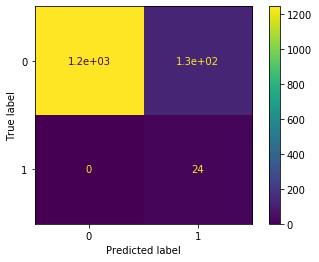

In [46]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

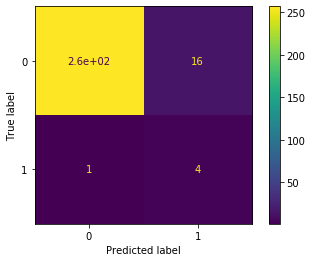

In [47]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [48]:
lr_y_pred = pipe.predict_proba(X_test)[:,1]
lr_y_pred[:5]

array([0.00292685, 0.00440431, 0.0044453 , 0.0044164 , 0.00305637])

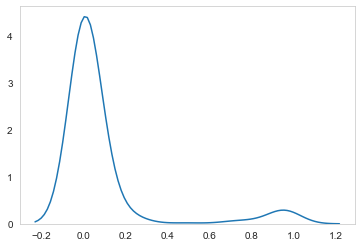

In [49]:
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(lr_y_pred);

In [50]:
metrics.confusion_matrix(y_test, lr_y_pred > 0.784)

array([[259,  14],
       [  1,   4]])

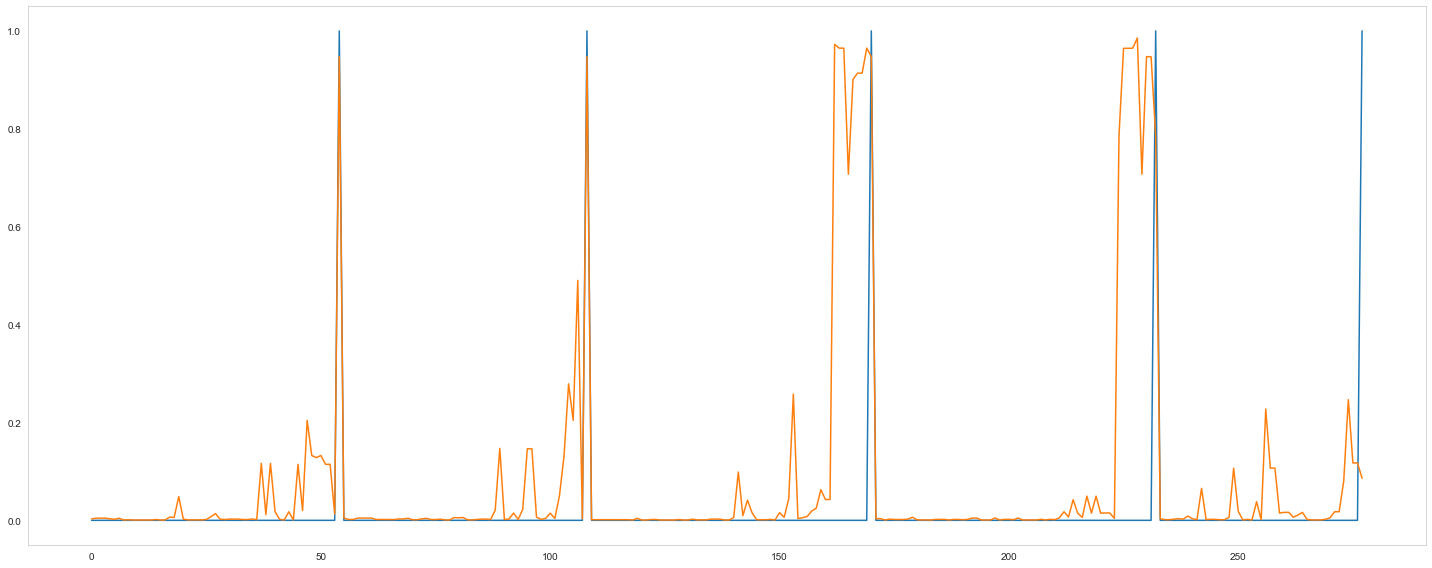

In [51]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(lr_y_pred)
plt.tight_layout()
plt.show()

In [96]:
exclude = ['winningTime', 'winningDate', 'precipType', 'Date', 'temperatureMin', 'temperatureMax',
           'precipAccumulation', 'moonPhase', 'noise_test']

# used_cols = [c for c in df_past.columns if c not in exclude]
# used_cols = ['precipIntensity', 'daylightHours', 'precip_snow', 'numColdDays', 'precip_rain',
#              'temperatureAvg', 'accumulatedSnow', 'numHotDays', 'iceThickness', 'windSpeed']
used_cols = ['precipIntensity', 'daylightHours', 'precip_snow', 'temperatureAvg', 'numColdDays']
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_svc = SVC(C = 1000,
              kernel = 'linear',
              gamma = 'auto',
              class_weight='balanced',
              random_state=42, probability=True)

pipe = make_pipeline(scaler, clf_svc)

X_train, y_train = df_past[used_cols].values, df_past[target].values
scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(), scoring=['f1_weighted',
                                                                                 'precision_weighted',
                                                                                 'recall_weighted',
                                                                                 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(),
      '+/-', scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-', scores['test_recall_weighted'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# 30 years' data
# f1_weighted: 0.9451545758095541 +/- 0.016296148051966726
# precision_weighted: 0.9824819520855975 +/- 0.003182243242772115
# recall_weighted: 0.9193133047210299 +/- 0.028130419928195583
# roc_auc: 0.9549720370795984 +/- 0.00956431482462009

f1_weighted: 0.8983164905177385 +/- 0.013769361050015638
precision_weighted: 0.9838626290464321 +/- 0.0013084188060260898
recall_weighted: 0.840343347639485 +/- 0.023255308470633597
roc_auc: 0.9497900865701372 +/- 0.005749782019919543


In [77]:
used_cols

['precipIntensity',
 'daylightHours',
 'precip_snow',
 'numColdDays',
 'precip_rain',
 'temperatureAvg',
 'accumulatedSnow',
 'numHotDays',
 'iceThickness',
 'windSpeed']

In [78]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('svc',
                 SVC(C=1000, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='auto',
                     kernel='linear', max_iter=-1, probability=True,
                     random_state=42, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

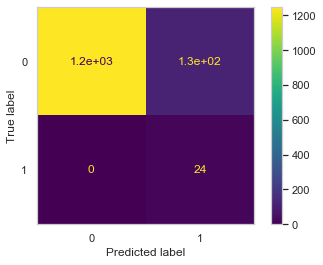

In [79]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

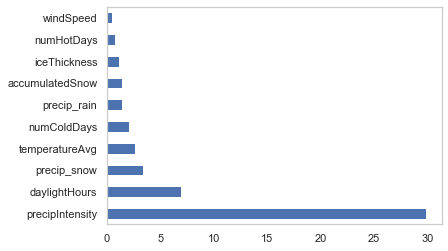

In [80]:
pd.Series(abs(clf_svc.coef_[0]), index=df_past[used_cols].columns).nlargest(10).plot(kind='barh');

In [81]:
X_test = df_future[used_cols]
y_test = df_future[target]
y_pred = pipe.predict(X_test)

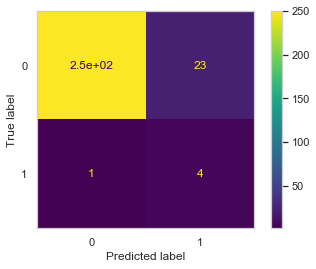

In [82]:
metrics.plot_confusion_matrix(pipe, X_test, y_test)

In [83]:
svc_y_pred = pipe.predict_proba(X_test)[:,1]
svc_y_pred[:5]

array([5.20830886e-05, 6.44778995e-05, 2.22827285e-05, 1.89838523e-04,
       3.89748165e-05])

In [84]:
metrics.confusion_matrix(y_test, svc_y_pred > 0.021)

array([[212,  61],
       [  0,   5]])

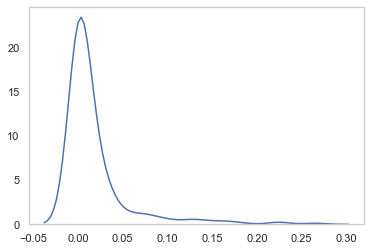

In [85]:
import seaborn as sns; sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(svc_y_pred);

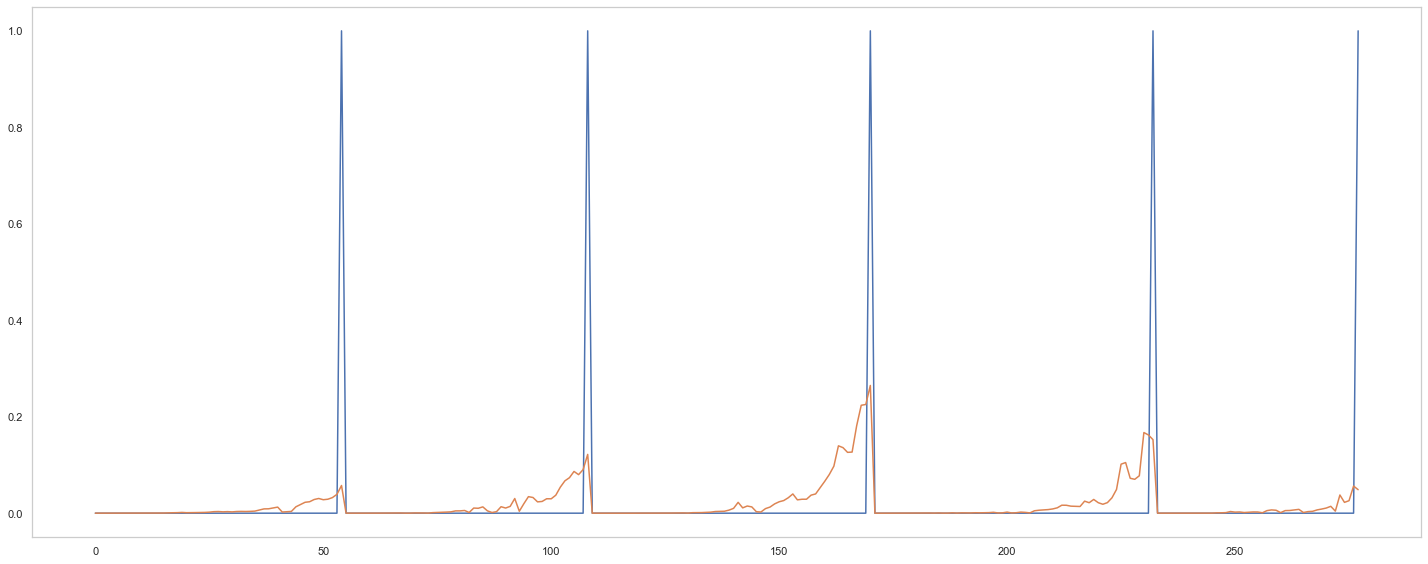

In [86]:
# plot of target vs predicted probability (multiplied by 10 so it was easier to see)
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(svc_y_pred)
plt.tight_layout()
plt.show()

In [87]:
blended_pred = np.mean( np.array([ lr_y_pred, svc_y_pred ]), axis=0 )

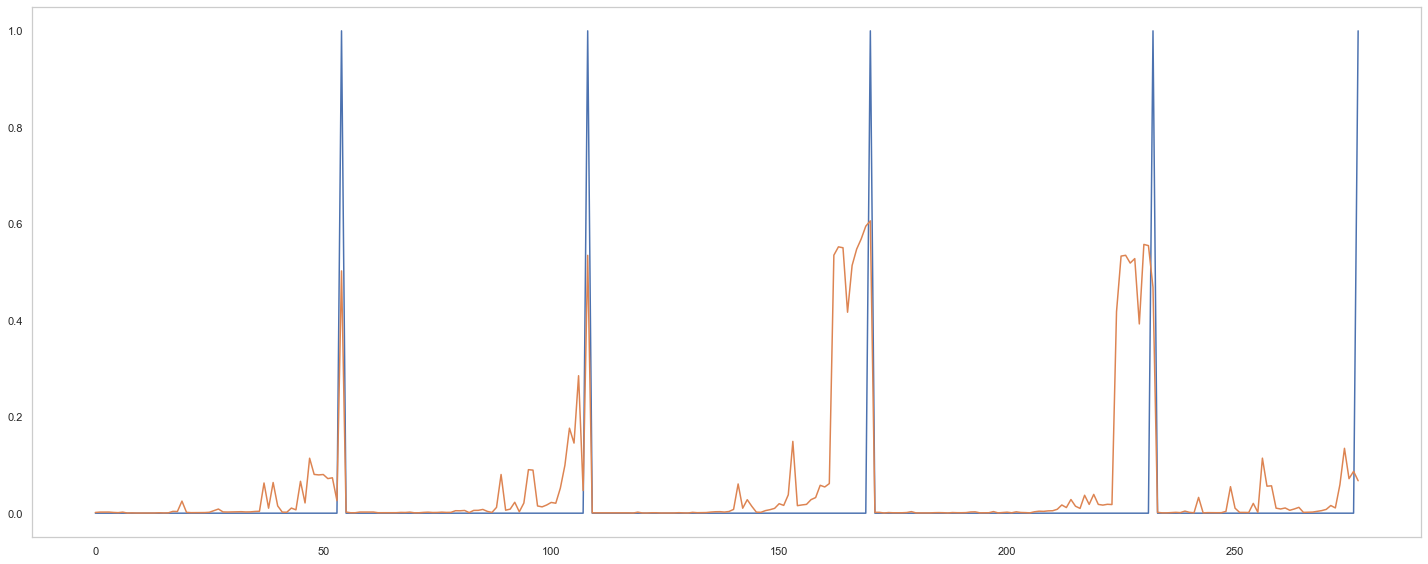

In [88]:
# plot of target vs two model averaged predicted probability
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(blended_pred)
plt.tight_layout()
plt.show()

_Notes_
* ~~add feature for day-of-year (to make the models time-aware);~~
* try hidden Markov model;
* ~~look at survival analysis/time-to-event analysis;~~
* look for outliers in training data, if removed, does model performance improve?;
* is there any way to identify mechanical failure of ice vs mush-out?;
* more time-series-like features, for instance number of "hot" days vs number of "cold" days; lags and rolling averages that Bryan talked about
* consider under- or over-sampling
* model stacking: http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/

survival analysis: https://lifelines.readthedocs.io/en/latest/

Kaggle competition modeling time-to-event: https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/94484

---
### Survival Analysis Application

**The daily approach:**
* "birth": start of day with ice intact
* "death": end of day with ice intact
* Censored: ice breaks before end of day
  * there will be 11 censored observations here
  
  If I do it this way, max lifespan will be 1 day; there will be 11 censored observations and I will need to calculate the duration for those.
  
  Use 24 hours as the duration; censored durations will be % of 24 hours before the break.

**OR, the annual approach:**
* "birth": start of observed period
* "death": ice breaks
* Censored: observed period ends with ice intact
  * there will be 0 censored observations here
  * I think this is the most promising
    * Y is % survival
    * X is day of year
  
  This worked, but not enough data to be stable. I want to try it the first way and see if that works.

---
old stuff below this line. only models yearly survival. not very accurate, needs more data, so I'm trying to work out a better model above

In [ ]:
df_survival = pd.read_csv('../data/ice_classic_winning_times.csv')

In [ ]:
df_survival.head()

In [ ]:
df_survival.info()

In [ ]:
df_survival['Time'] = df_survival['Date'] + ' ' + df_survival['Time']
df_survival['Date'] = pd.to_datetime(df_survival['Date'])
df_survival['Time'] = pd.to_datetime(df_survival['Time'])

In [ ]:
df_survival['day_of_year'] = df_survival['Date'].dt.dayofyear

In [ ]:
df_survival['observed'] = 1

In [ ]:
df_survival['observation_entry'] = 91 # change to 59 for data starting in March

In [ ]:
df_survival.head()

In [ ]:
from lifelines import ( KaplanMeierFitter, WeibullFitter, ExponentialFitter,
LogNormalFitter, LogLogisticFitter, NelsonAalenFitter,
PiecewiseExponentialFitter, GeneralizedGammaFitter, SplineFitter, CoxPHFitter)

from lifelines.plotting import plot_lifetimes
from lifelines.utils import datetimes_to_durations

In [ ]:
# create knots for lifelines spline fitter
surv_min = df_survival['day_of_year'].min()
surv_1q = df_survival['day_of_year'].quantile(0.25)
surv_med = df_survival['day_of_year'].median()
surv_3q = df_survival['day_of_year'].quantile(0.75)
surv_max = df_survival['day_of_year'].max()

In [ ]:
mod_kmf = KaplanMeierFitter()
mod_wbf = WeibullFitter()
mod_exf = ExponentialFitter()
mod_lnf = LogNormalFitter()
mod_naf = NelsonAalenFitter()
mod_llf = LogLogisticFitter()
mod_pwf = PiecewiseExponentialFitter([120, 135])
mod_gg = GeneralizedGammaFitter()
mod_spf = SplineFitter([surv_min, surv_1q, surv_med, surv_3q, surv_max])

In [ ]:
T = df_survival['day_of_year']
E = df_survival['observed']

mod_kmf.fit(T, event_observed=E)

In [ ]:
mod_kmf.survival_function_.plot(figsize = (10,6))
plt.title('Survival function of Tanana River ice at Nenana, AK');

In [ ]:
mod_kmf.plot(figsize = (10,6));
plt.title('KM Estimate of Tanana River ice at Nenana, AK w/confidence interval');

In [ ]:
mod_kmf.median_survival_time_

In [ ]:
plt.figure(figsize = (10, 6))
plot_lifetimes(durations = df_survival['day_of_year'],
               event_observed = df_survival['observed'])
plt.xlabel('Timeline (days since Jan 1)')
plt.ylabel('Sample Number')
plt.title('Lifetime of Tanana River ice at Nenana, AK');

In [ ]:
wf = mod_wbf.fit(T, E)

wf.print_summary()

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

wbf = mod_wbf.fit(T, E, label='WeibullFitter')
exf = mod_exf.fit(T, E, label='ExponentalFitter')
lnf = mod_lnf.fit(T, E, label='LogNormalFitter')
kmf = mod_kmf.fit(T, E, label ='KaplanMeierFitter')
naf = mod_naf.fit(T, E, label='NelsonAalenFitter')
llf = mod_llf.fit(T, E, label='LogLogisticFitter')
pwf = mod_pwf.fit(T, E, label='PiecewiseExponentialFitter')
gg = mod_gg.fit(T, E, label='GeneralizedGammaFitter')
spf = mod_spf.fit(T, E, label='SplineFitter')

wbf.plot_cumulative_hazard(ax=axes[0][0])
exf.plot_cumulative_hazard(ax=axes[0][1])
lnf.plot_cumulative_hazard(ax=axes[0][2])
naf.plot_cumulative_hazard(ax=axes[1][0])
llf.plot_cumulative_hazard(ax=axes[1][1])
pwf.plot_cumulative_hazard(ax=axes[1][2])
gg.plot_cumulative_hazard(ax=axes[2][0])
spf.plot_cumulative_hazard(ax=axes[2][1]);

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

wbf.plot_survival_function(ax=axes[0][0])
exf.plot_survival_function(ax=axes[0][1])
lnf.plot_survival_function(ax=axes[0][2])
kmf.plot_survival_function(ax=axes[1][0])
llf.plot_survival_function(ax=axes[1][1])
pwf.plot_survival_function(ax=axes[1][2])
gg.plot_survival_function(ax=axes[2][0])
spf.plot_survival_function(ax=axes[2][1]);

In [ ]:
df_survival

_Example:_
"""
     week  arrest  fin  age  race  wexp  mar  paro  prio
0      20       1    0   27     1     0    0     1     3
1      17       1    0   18     1     0    0     1     8
2      25       1    0   19     0     1    0     1    13
3      52       0    1   23     1     1    1     1     1
"""
The week column is the duration, the arrest column is the event occurred, and the other columns represent variables we wish to regress against.

['numColdDays', 'iceThickness', 'dayOfYear', 'uvIndex', 'precipIntensity', 'humidity']


Use past & future sets for splits

_(before doing all these experiments manually, might want to consider using RFE or similar)_

Experiment 1:
| date | day_of_year | duration | break_observed | cold_days | ice_thickness | uv_index | precip_intensity | precip_accumulation |
|---|---|---|---|---|---|---|---|---|

Experiment 2:
| date | day_of_year | duration | break_observed | hot_days | ice_thickness | uv_index | precip_intensity | precip_accumulation |
|---|---|---|---|---|---|---|---|---|

Experiment 3:
| date | day_of_year | duration | break_observed | cold_days | avg_temp | ice_thickness | uv_index | precip_intensity | precip_accumulation |
|---|---|---|---|---|---|---|---|---|---|

Experiment 4:
| date | day_of_year | duration | break_observed | hot_days | avg_temp | ice_thickness | uv_index | precip_intensity | precip_accumulation |
|---|---|---|---|---|---|---|---|---|---|


| date | day_of_year | duration | break_observed | hot_days | cold_days | avg_temp? | min_temp? | max_temp? | ice_thickness | uv_index | precip_intensity | precip_accumulation? | humidity? |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|


| date | day_of_year | duration | break_observed | hot_days | cold_days | avg_temp? | min_temp? | max_temp? | ice_thickness | uv_index | precip_intensity | precip_accumulation? | humidity? |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|


| date | day_of_year | duration | break_observed | hot_days | cold_days | avg_temp? | min_temp? | max_temp? | ice_thickness | uv_index | precip_intensity | precip_accumulation? | humidity? |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|

In [ ]:
df_past.columns

In [ ]:
# df_past_surv = df_past.copy()

In [ ]:
# df_past_surv.drop(columns = ['moonPhase', 'atmoPressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover',
#                   'precipType', 'precipAccumulation', 'precip_rain', 'precip_snow', 'noise_test'],
#                   inplace = True)

In [ ]:
# df_past_surv['duration'] = 1

In [ ]:
# df_past_surv['winningTime'].value_counts()

In [ ]:
# df_past_surv.loc[idx_w]['winningTime']

In [ ]:
# for row in idx_w:
#     win_time = df_past_surv.loc[row]['winningTime']
#     win_time = pd.to_datetime(win_time)
#     dur = win_time.minute + win_time.hour * 60
#     dur_pcnt = dur / 1440
#     df_past_surv['duration'].loc[row] = dur_pcnt

Experiment 1:
| date | day_of_year | duration | break_observed | cold_days | ice_thickness | uv_index | precip_intensity | precip_accumulation |
|---|---|---|---|---|---|---|---|---|

Experiment 2:
| date | day_of_year | duration | break_observed | hot_days | ice_thickness | uv_index | precip_intensity | precip_accumulation |
|---|---|---|---|---|---|---|---|---|

In [ ]:
# df_past_surv.columns

In [ ]:
# df_past_surv['numHotDays'].value_counts()

I drop the 'numHotDays' columns from df_past_surv since all values are 0.

In [ ]:
# df_past_surv.drop(columns = 'numHotDays', inplace = True)

In [ ]:
# df_past_surv.corr()

In [ ]:
# # drop_cols = ['Date', 'humidity', 'temperatureMin', 'temperatureMax', 'winningTime', 'daylightHours', 'precipIntensity']
# drop_cols = ['Date', 'winningTime', 'temperatureMin', 'temperatureMax', 'precipIntensity']
# X = df_past_surv.drop(columns = drop_cols)
# dur = df_past_surv['duration']
# obs = df_past_surv['winningDate']

# cph = CoxPHFitter()
# cph.fit(X, duration_col='duration', event_col='winningDate')

# cph.print_summary()  # access the results using cph.summary
# cph.plot();

In [ ]:
# prediction examples, X is the dataset
# cph.predict_partial_hazard(X)
# cph.predict_survival_function(X)
# cph.predict_median(X)

# filter down to censored observations to predict further survival
# censored_subjects = X.loc[~obs.astype(bool)]
# censored_subjects_last_obs = censored_subjects['duration']

# cph.predict_survival_function(censored_subjects,
#                               times=[5., 25., 50.],
#                               conditional_after=censored_subjects_last_obs)
# cph.predict_median(censored_subjects,
#                    conditional_after=censored_subjects_last_obs)

In [ ]:
# T = df_past_surv['duration']
# E = df_past_surv['winningDate']

In [ ]:
# fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# wbf = mod_wbf.fit(T, E, label='WeibullFitter')
# exf = mod_exf.fit(T, E, label='ExponentalFitter')
# lnf = mod_lnf.fit(T, E, label='LogNormalFitter')
# kmf = mod_kmf.fit(T, E, label ='KaplanMeierFitter')
# naf = mod_naf.fit(T, E, label='NelsonAalenFitter')
# llf = mod_llf.fit(T, E, label='LogLogisticFitter')
# pwf = mod_pwf.fit(T, E, label='PiecewiseExponentialFitter')
# gg = mod_gg.fit(T, E, label='GeneralizedGammaFitter')
# spf = mod_spf.fit(T, E, label='SplineFitter')

# wbf.plot_cumulative_hazard(ax=axes[0][0])
# exf.plot_cumulative_hazard(ax=axes[0][1])
# lnf.plot_cumulative_hazard(ax=axes[0][2])
# naf.plot_cumulative_hazard(ax=axes[1][0])
# llf.plot_cumulative_hazard(ax=axes[1][1])
# pwf.plot_cumulative_hazard(ax=axes[1][2])
# gg.plot_cumulative_hazard(ax=axes[2][0])
# spf.plot_cumulative_hazard(ax=axes[2][1]);

In [ ]:
# fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# wbf.plot_survival_function(ax=axes[0][0])
# exf.plot_survival_function(ax=axes[0][1])
# lnf.plot_survival_function(ax=axes[0][2])
# kmf.plot_survival_function(ax=axes[1][0])
# llf.plot_survival_function(ax=axes[1][1])
# pwf.plot_survival_function(ax=axes[1][2])
# gg.plot_survival_function(ax=axes[2][0])
# spf.plot_survival_function(ax=axes[2][1]);

In [ ]:
df_survival['past'] = (df_survival['Date'] < '2015-01-01').astype(np.int)
df_survival['future'] = 1 - df_survival['past']

In [ ]:
df_survival.head()

In [ ]:
drop_cols = ['Date', 'Time', 'past', 'future']
X_past = df_survival.loc[df_survival['past'] == 1].drop(columns = drop_cols)

In [ ]:
T_p = X_past['day_of_year']
E_p = X_past['observed']

In [ ]:
cph = CoxPHFitter()

In [ ]:
X_future = df_survival.loc[df_survival['future'] == 1].drop(columns = drop_cols)
T_f = X_future['day_of_year']
E_f = X_future['observed']

In [ ]:
exclude = ['Date', 'moonPhase', 'atmoPressure', 'windSpeed', 'windGust', 'windBearing', 'precip_rain',
           'precip_snow', 'noise_test', 'precipType', 'winningTime', 'numHotDays', 'temperatureMin',
           'temperatureMax', 'precipAccumulation']
X_train = df_past.drop(columns = exclude)
X_test = df_future.drop(columns = exclude)

In [ ]:
test = cph.fit(X_train, 'dayOfYear', 'winningDate')

In [ ]:
test.score_

In [ ]:
test.print_summary()

In [ ]:
np.random.seed(seed = 42)

In [ ]:
from lifelines.utils import k_fold_cross_validation

cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, X_train, 'dayOfYear', event_col='winningDate', k=5)
print(np.mean(scores), '+/-', np.std(scores))

In [ ]:
models = []
for i in range(10):
    cph = CoxPHFitter()
    models.append(cph)
    
predictions = []
for model in models:
    model.fit(X_train, 'dayOfYear')
    pred = model.predict_expectation(X_test)
    predictions.append(pred.values)
    
np.mean(predictions), np.std(predictions)

In [ ]:
predictions = []
for model in models:
    model.fit(X_train, 'dayOfYear')
    pred = model.predict_survival_function(X_test)
    predictions.append(pred.values)
    
predictions[0]

In [ ]:
predictions[0][0,:].shape

In [ ]:
plt.scatter(range(181), predictions[0][31,:])